In [1]:
%load_ext line_profiler
%load_ext memory_profiler

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import util
import models

from os.path import expanduser
from os import path

import matplotlib.pyplot as plt
import seaborn as sns

import yass
from yass import read_config
from yass.augment import (make_training_data,
                          save_detect_network_params,
                          save_triage_network_params,
                          save_ae_network_params,
                          train_detector,
                          train_ae,
                          train_triage,
                          make)
from yass.explore import RecordingExplorer, SpikeTrainExplorer

import numpy as np
from scipy.io import loadmat

plt.rcParams['figure.figsize'] = (10, 10)

Using TensorFlow backend.


In [4]:
yass.set_config("../config/49-lab.yaml")
CONFIG = read_config()

In [5]:
path_to_data = path.expanduser('~/data')
path_to_ground_truth = path.join(path_to_data,
                                 'groundtruth_ej49_data1_set1.mat')
path_to_standarized = path.join(path_to_data, 'tmp', 'preprocess',
                               'standarized.bin')
path_to_geom = path.join(path_to_data, 'ej49_geometry1.txt')

In [6]:
# load ground truth
_ = loadmat(path_to_ground_truth)
gt = np.hstack([_['spt_gt'], _['L_gt']])

In [7]:
gt = gt[2:-1]

In [8]:
gt[:, 1] = gt[:, 1] - 1

In [9]:
re = RecordingExplorer(path_to_standarized, spike_size=15)
se = SpikeTrainExplorer(gt, re)

In [17]:
def spike_amplitudes_from_spikes(spikes):
    return np.max(np.abs(spikes), axis=(0, 1))

In [18]:
amps = spike_amplitudes_from_spikes(se.templates)

In [19]:
np.argsort(amps)

array([22, 40, 46, 32, 43, 20, 21,  2, 29, 34, 12, 47, 35, 11, 14, 37, 13,
       38, 41, 39, 31, 30,  6, 10, 42, 24, 15, 45, 16,  1, 36, 44, 33, 17,
       48, 19,  0,  7, 28, 26,  4, 23, 18,  3, 25, 27,  8,  5,  9])

In [20]:
amps[[8, 5, 9]]

array([30.884478, 42.622433, 59.108902], dtype=float32)

/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


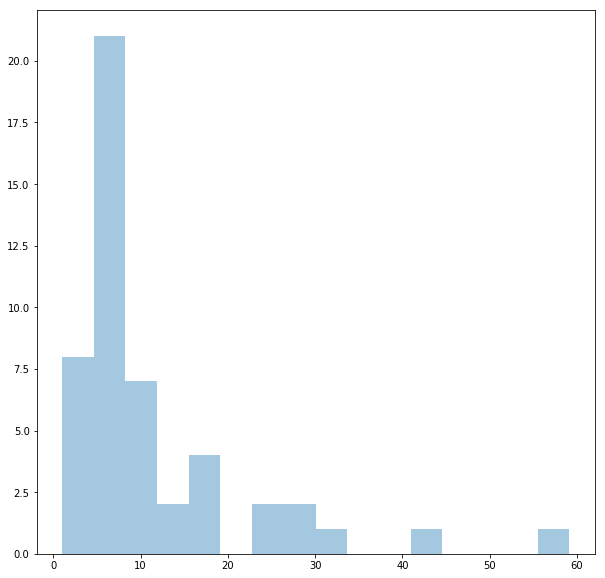

In [21]:
sns.distplot(amps, kde=False)

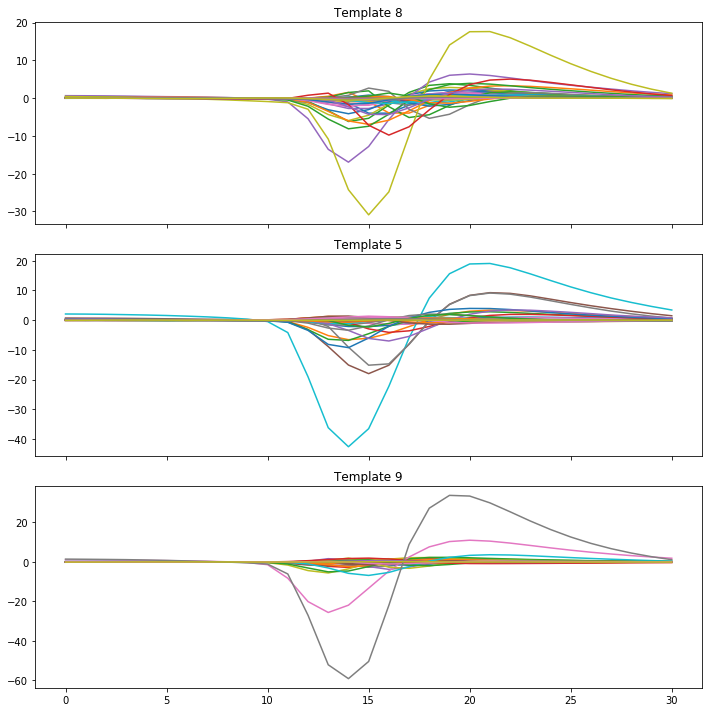

In [22]:
se.plot_templates(group_ids=[8, 5, 9])

## Generating data

In [23]:
min_amp = 5
nspikes = 50000
n_templates = np.max(gt[:,1]) + 1
chosen_templates = np.arange(n_templates)

In [25]:
(x_detect,
 y_detect,
 x_triage,
 y_triage,
 x_ae,
 y_ae) = make_training_data(CONFIG, gt, chosen_templates,
                            min_amp, nspikes,
                            data_folder='/home/Edu/data/nnet/')

100%|██████████| 113/113 [00:03<00:00, 31.92it/s]


In [26]:
x_detect.shape

(650052, 21, 7)

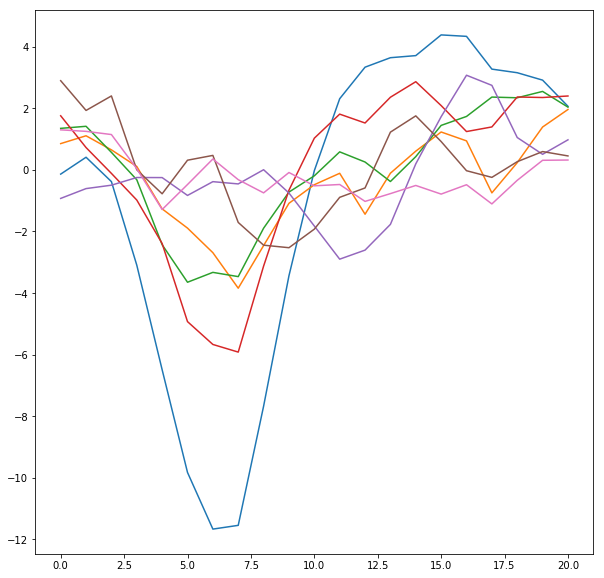

In [27]:
_ = plt.plot(x_detect[200])

In [31]:
x_detect_positive = x_detect[y_detect == 1]
x_detect_negative = x_detect[y_detect == 0]

In [32]:
amps_positive = np.max(np.abs(x_detect_positive), axis=(1, 2))
amps_negative = np.max(np.abs(x_detect_negative), axis=(1, 2))

/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


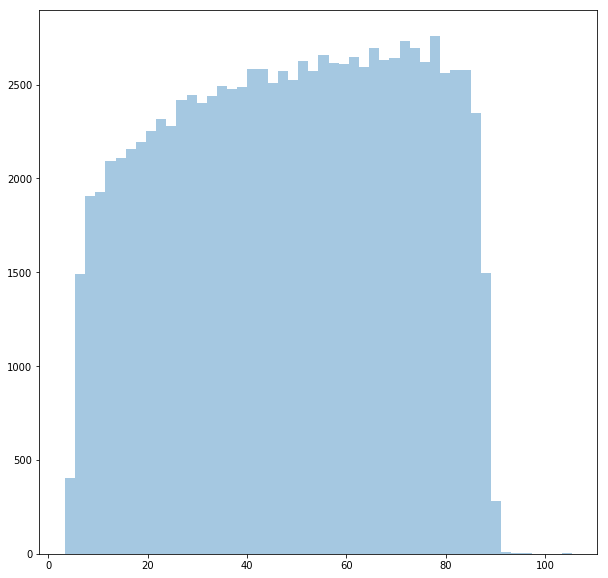

In [33]:
_ = sns.distplot(amps_positive, kde=False)


/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


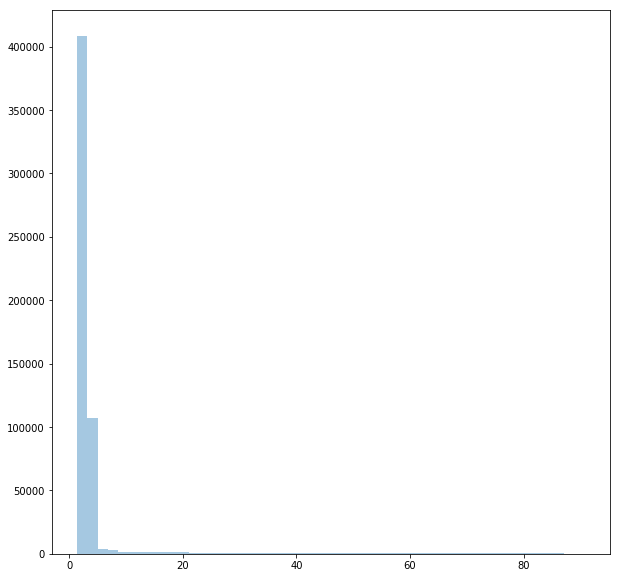

In [34]:
_ = sns.distplot(amps_negative, kde=False)

## Training detector

In [112]:
import util

In [116]:
n_iter = 50000
n_batch = 512
l2_reg_scale = 0.00000005
train_step_size =  0.001

detectnet_name = path.join('models', 'detect-'+util.directory())
n_filters_detect = [8, 4]

In [ ]:
train_detector(x_detect, y_detect,
               n_filters_detect, n_iter,
               n_batch, l2_reg_scale,
               train_step_size,
               detectnet_name)

129194775it [04:29, 963591.71it/s]                      